# Analysis of Control Samples

In [1]:
%load_ext rpy2.ipython

import pandas as pd
from capalyzer.packet_parser import DataTableFactory

PACKET_DIR = '/home/dcdanko/Dropbox/resources_and_shared/metasub_data_packets/metasub_data_packet_v1_0/'
METADATA = PACKET_DIR + 'metadata/complete_metadata.csv'
metadata = pd.read_csv(METADATA, index_col=0)
control_metadata = metadata[~metadata['control_type'].isna()]
city_metadata = pd.read_csv(PACKET_DIR + 'metadata/city_metadata.csv', index_col=0)
tabler = DataTableFactory(PACKET_DIR, metadata_tbl=control_metadata)

In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)

greyscale = function(n){
    return(rev(grey.colors(n)))
}

In [3]:
taxa = tabler.taxonomy(normalize=True)
taxa = (taxa.T[taxa.sum(axis=0) > 0]).T
taxa = taxa.fillna(0)
taxa = taxa[taxa.sum(axis=1) > 0]

control_metadata = control_metadata.loc[taxa.index]
taxa.shape

(77, 1783)

# Inter Control Distance

The Taxonomic Distance between controls computed with two metrics

In [4]:
jsd = tabler.beta_diversity(taxa)
jsd = jsd.fillna(1)

rho = tabler.beta_diversity(taxa, metric='rho')
rho = rho.fillna(1)

def control_colors(val):
    if val in ('positive_control', 'poszymo'):
        return 'green'
    elif val == 'ctrl cities':
        return 'blue'
    elif val in ('dry tube', 'dry tube & swab', 'tube & rna/dna out', 'tube & rna/dna out & swab'):
        return 'orange'
    return 'red'

control_cols = control_metadata['control_type'].apply(control_colors)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


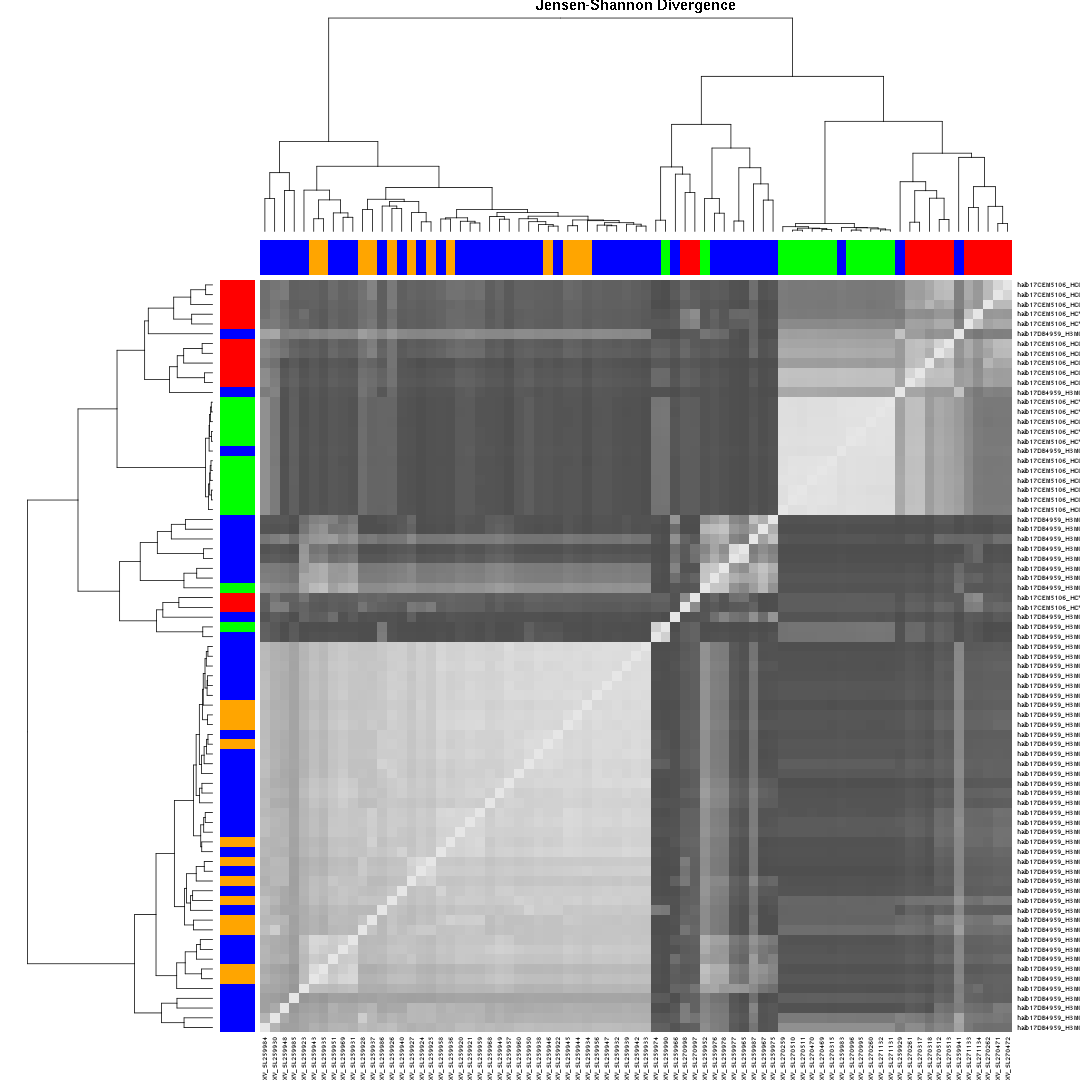

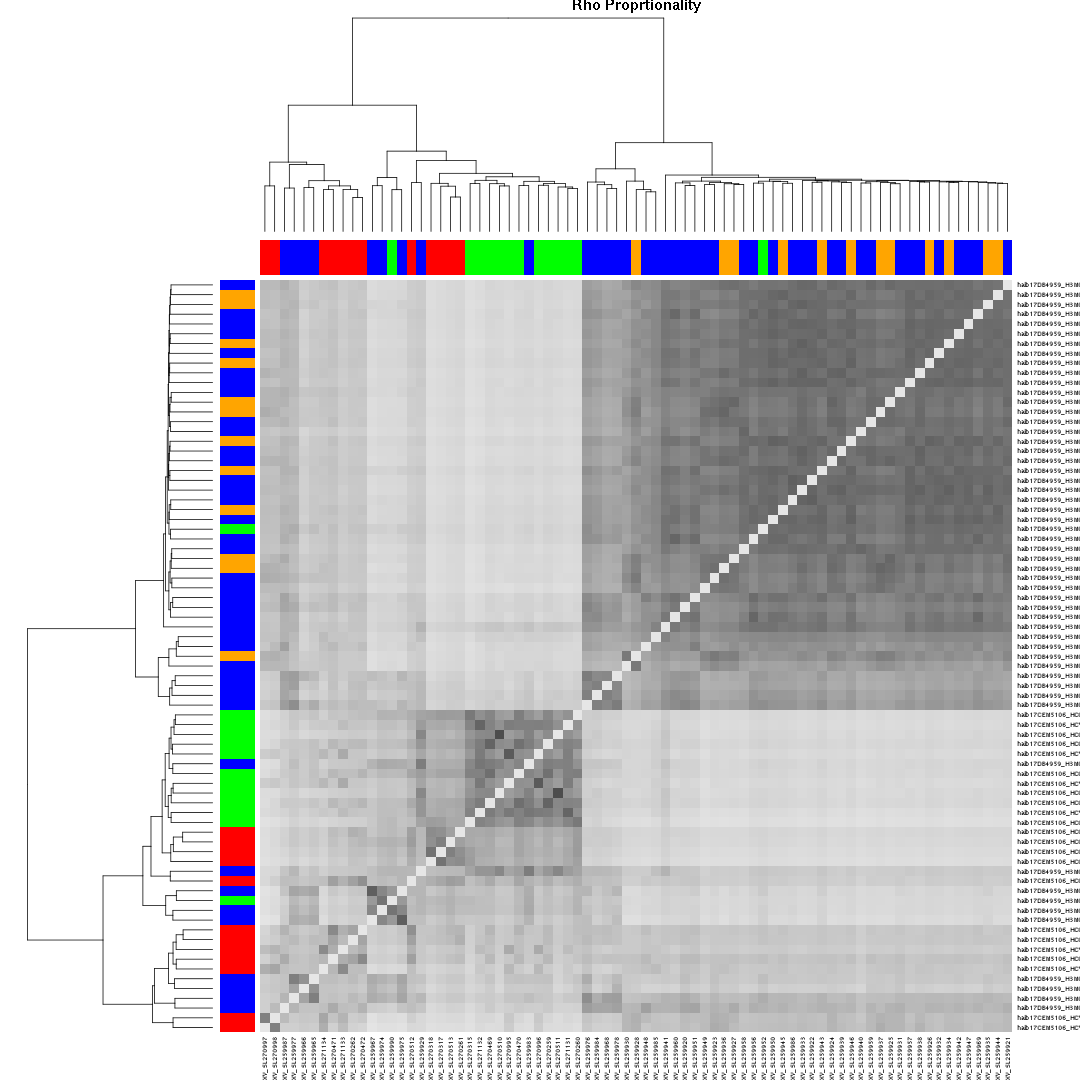

In [5]:
%%R -i jsd -i rho -i control_cols --height 1080 --width 1080

jsd = as.matrix(jsd)
rho = as.matrix(rho)

heatmap(
    jsd,
    col=greyscale(256),
    ColSideColors=control_cols,
    RowSideColors=control_cols,
    scale='none',
    main='Jensen-Shannon Divergence'
)

heatmap(
    rho,
    col=greyscale(256),
    ColSideColors=control_cols,
    RowSideColors=control_cols,
    scale='none',
    main='Rho Proprtionality',
)

## Positive Controls

Identify the major taxa in positive control samples

In [6]:
pos_taxa = taxa[control_metadata['control_type'].isin(('positive_control', 'poszymo'))]

pos_taxa_2 = (pos_taxa.T[pos_taxa.max(axis=0) > 0.0001]).T
pos_taxa = (pos_taxa.T[pos_taxa.max(axis=0) > 0.01]).T


zymo_taxa = {
    'Bacillus subtilis',
    'Cryptococcus neoformans',
    'Enterococcus faecalis',
    'Escherichia coli',
    'Lactobacillus fermentum',
    'Listeria monocytogenes',
    'Pseudomonas aeruginosa',
    'Saccharomyces cerevisiae',
    'Salmonella enterica',
    'Staphylococcus aureus',
}
def color_taxa(val):
    if val in zymo_taxa:
        return 'green'
    return 'red'

taxa_cols = [color_taxa(taxa) for taxa in pos_taxa.columns]
pos_taxa.shape
len(taxa_cols)

14

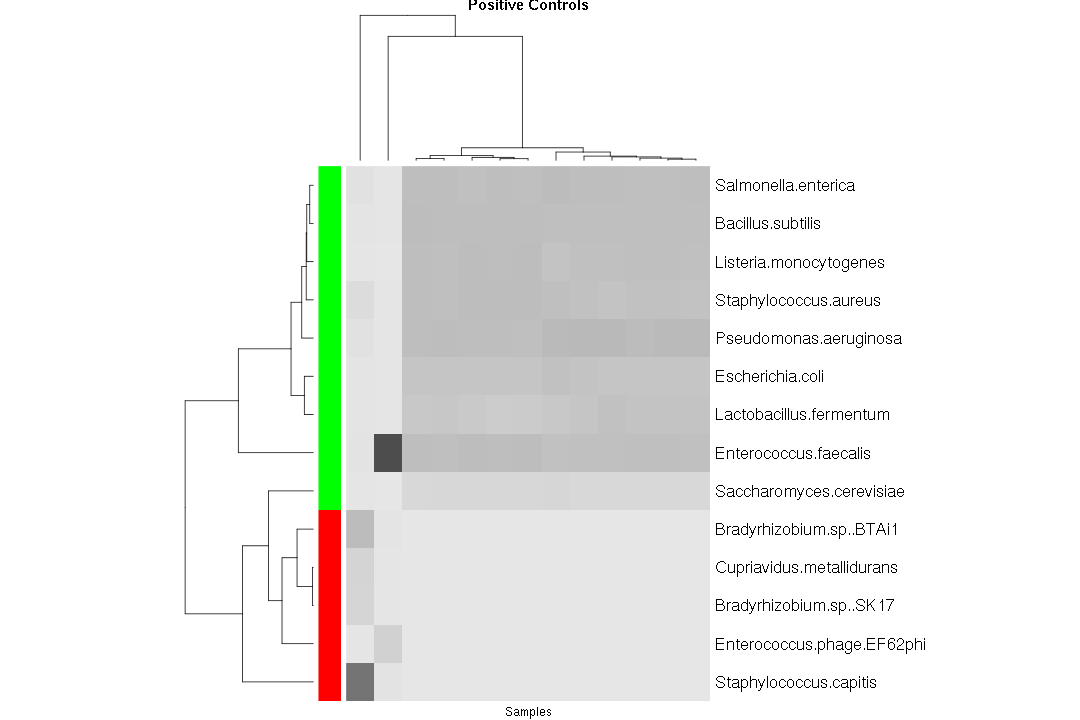

In [7]:
%%R -i pos_taxa -i taxa_cols --height 720 --width 1080

pos_taxa = sqrt(t(as.matrix(pos_taxa)))

heatmap(
    pos_taxa,
    scale='none',
    col=greyscale(256),
    margins=c(2, 20),
    main='Positive Controls',
    RowSideColors=unlist(taxa_cols),
    xlab='Samples',
    labCol=NA,
    cexRow=2
)

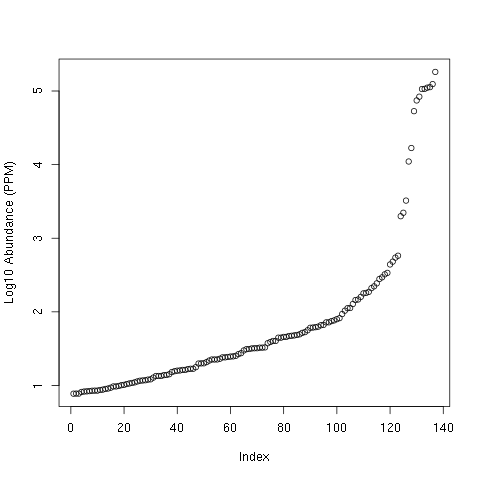

In [8]:
%%R -i pos_taxa_2 -i taxa_cols

plot(
    sort(log10(1000 * 1000 * colMeans(pos_taxa_2))),
    ylab= 'Log10 Abundance (PPM)'

)

### Discusion

The positive controls generally look pretty good EXCEPT that they are all missing Cryptococcus neoformans?

## Negative Controls

Analysis of major taxa in negative cotnrol samples.


In [9]:
neg_taxa = taxa[~control_metadata['control_type'].isin(('positive_control', 'poszymo'))]
neg_taxa = (neg_taxa.T[neg_taxa.max(axis=0) > 0.01]).T


def prevalence(df, thresh=0, count=False):
    """Return the prevalence of each column in a dataframe."""
    return (df > thresh).sum(axis=0) / (1 if count else df.shape[0])

neg_taxa_prev = neg_taxa.apply(prevalence)

def neg_control_colors(val):
    col_map = {
        'ctrl cities': 'blue',
        'dry tube': 'white',
        'dry tube & swab': 'yellow',
        'tube & rna/dna out': 'orange',
        'tube & rna/dna out & swab': 'red',
    }
    try:
        return col_map[val]
    except KeyError:
        return 'green'


neg_control_cols = control_metadata['control_type'][neg_taxa.index].apply(neg_control_colors)
neg_taxa.shape

(64, 61)

In [12]:
neg_taxa.columns

Index(['Salmonella enterica', 'Escherichia coli', 'Serratia marcescens',
       'Pseudomonas stutzeri', 'Pseudomonas aeruginosa', 'Pseudomonas putida',
       'Pseudomonas fluorescens', 'Stenotrophomonas sp. LM091',
       'Stenotrophomonas maltophilia', 'Bradyrhizobium sp. SK17',
       'Bradyrhizobium sp. BTAi1', 'Bradyrhizobium diazoefficiens',
       'Bradyrhizobium japonicum', 'Bradyrhizobium sp.',
       'Bradyrhizobium sp. CCGE-LA001', 'Bradyrhizobium sp. S23321',
       'Rhodopseudomonas palustris', 'Methylobacterium populi',
       'Ochrobactrum anthropi', 'Ochrobactrum sp. A44',
       'Ochrobactrum pseudogrignonense', 'Brevundimonas naejangsanensis',
       'Brevundimonas sp. DS20', 'Altererythrobacter marensis',
       'Achromobacter xylosoxidans', 'Janthinobacterium sp. 1_2014MBL_MicDiv',
       'Janthinobacterium svalbardensis', 'Janthinobacterium sp. LM6',
       'Cupriavidus metallidurans', 'Ralstonia pickettii', 'Bacillus subtilis',
       'Staphylococcus aureus', 'Sta

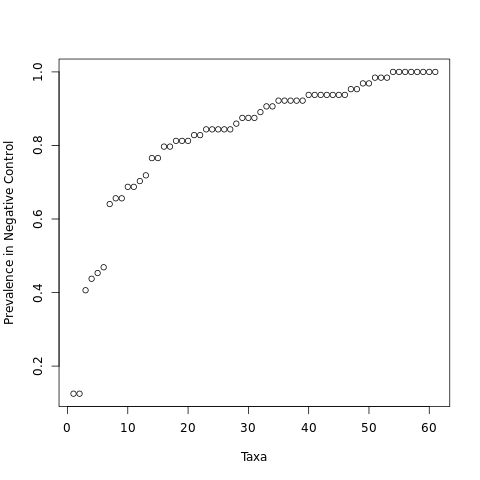

In [171]:
%%R -i neg_taxa_prev

plot(sort(neg_taxa_prev), xlab='Taxa', ylab='Prevalence in Negative Control')

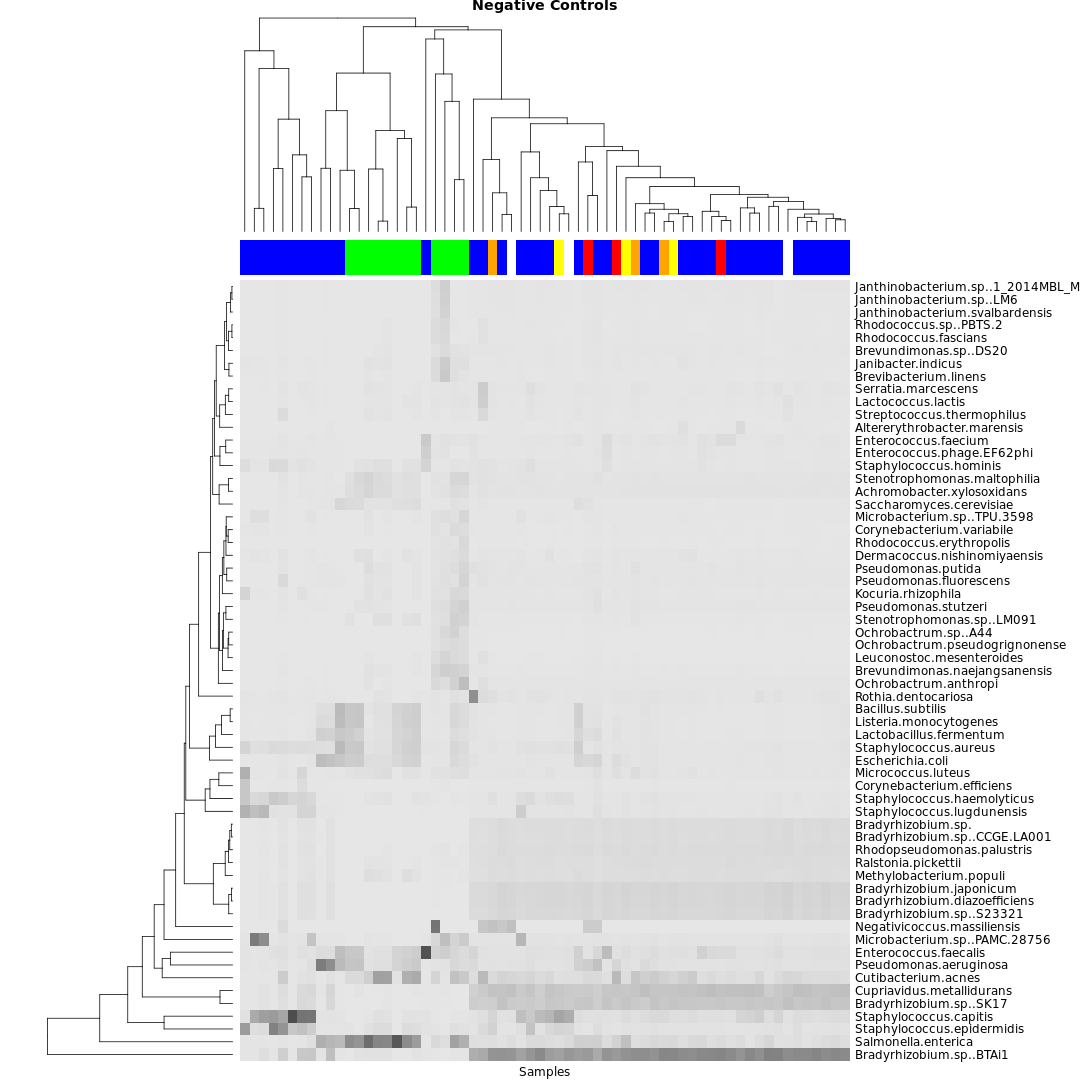

In [177]:
%%R -i neg_taxa -i neg_control_cols --height 1080 --width 1080

neg_taxa = sqrt(t(as.matrix(neg_taxa)))

heatmap(
    neg_taxa,
    scale='none',
    col=greyscale(256),
    margins=c(2, 20),
    main='Negative Controls',
    ColSideColors=unlist(neg_control_cols),
    xlab='Samples',
    labCol=NA,
    cexRow=1.5
)

### Discussion

Bradyrhizobium, Salmonella enterica, Staph epi and Staph capitis are all abundant in a number of negative controls. A number of other taxa are reasonably prevalent or abundant in a few samples.

The abundant taxa appear to cluster by the type of negative control.

## Discussion and To Do

Might be worth digging into the kmer profiles of negative control taxa. Are these kmer profiles smooth or spiky?

In [7]:
cacnes = pd.read_csv(
    '/home/dcdanko/Sci/gimmesci/metasub/cacnes_metasub_taxa.csv', index_col=0, header=0,
)
cacnes.columns = ['taxa', 'taxid', 'rank', 'mpa',' cov','dup','kmers','percent', 'reads','taxa reads']
cacnes['control'] = metadata['control_type'][cacnes.index]
cacnes.head()

,taxa,taxid,rank,mpa,cov,dup,kmers,percent,reads,taxa reads,control
haib17CEM4890_H2NYMCCXY_SL254769,,,,,,,,,,,
haib17CEM4890_H2NYMCCXY_SL254770,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,0.01875,1.54,77642,0.002356,688,670,NaN
haib17CEM4890_H2NYMCCXY_SL254771,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,0.01322,1.52,54758,0.001796,482,471,NaN
haib17CEM4890_H2NYMCCXY_SL254772,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,0.02391,1.53,99020,0.003137,863,822,NaN
haib17CEM4890_H2NYMCCXY_SL254773,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,0.72690,3.88,3010317,0.457200,62250,59317,NaN
haib17CEM4890_H2NYMCCXY_SL254774,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,0.69680,4.14,2885910,0.722700,65539,62826,NaN


In [ ]:
%%R -i cacnes --height 540 --width 810

dup_cutoff = median(cacnes$dup) - 2 * mad(cacnes$dup)
kmer_cutoff = median(cacnes$kmers) + 2 * mad(cacnes$kmers)
print(dup_cutoff)
print(kmer_cutoff)
ggplot(cacnes, aes(x=dup, y=kmers, col=control)) +
    geom_point() + 
    ggtitle('Cutibacterium Acnes') +
    geom_hline(yintercept=kmer_cutoff, col='red') +
    geom_vline(xintercept=dup_cutoff, col='red') +
    scale_y_log10() +
    scale_x_log10() +
    theme_minimal() +
    ylab('Number of Kmers') +
    xlab('Mean Kmer Copy Number') + 
    theme_minimal() +
    theme(
        text=element_text(size=15),
    )

In [234]:
metadata.head()

,metasub_name,core_project,project,city,city_code,latitude,longitude,surface_material,control_type,elevation,...,hudson_alpha_flowcell,hudson_alpha_project,index_sequence,location_type,hudson_alpha_uid,other_project_uid,plate_number,plate_pos,sample_type,sl_name
uuid,,,,,,,,,,,,,,,,,,,,,
haib17CEM4890_H75CGCCXY_SL263637,CSD16-AKL-002,core,CSD16,auckland,AKL,-36.862361,174.809565,glass,NaN,NaN,...,H75CGCCXY,haib17CEM4890,GCGTTTG,NaN,haib17CEM4890_H75CGCCXY_SL263637,NaN,NaN,NaN,environmental_microbiome,SL263637
haib17CEM4890_H75CGCCXY_SL263649,CSD16-AKL-003,core,CSD16,auckland,AKL,-36.862437,174.809512,metal,NaN,NaN,...,H75CGCCXY,haib17CEM4890,TACTCCC,NaN,haib17CEM4890_H75CGCCXY_SL263649,NaN,NaN,NaN,environmental_microbiome,SL263649
haib17CEM4890_H75CGCCXY_SL263661,CSD16-AKL-006,core,CSD16,auckland,AKL,-36.862345,174.809494,metal,NaN,NaN,...,H75CGCCXY,haib17CEM4890,ACCACTG,NaN,haib17CEM4890_H75CGCCXY_SL263661,NaN,NaN,NaN,environmental_microbiome,SL263661
haib17CEM4890_H75CGCCXY_SL263673,CSD16-AKL-007,core,CSD16,auckland,AKL,-36.866272,174.820725,wood,NaN,NaN,...,H75CGCCXY,haib17CEM4890,CACCTGA,NaN,haib17CEM4890_H75CGCCXY_SL263673,NaN,NaN,NaN,environmental_microbiome,SL263673
haib17CEM4890_H75CGCCXY_SL263685,CSD16-AKL-008,core,CSD16,auckland,AKL,-36.866310,174.820751,glass,NaN,NaN,...,H75CGCCXY,haib17CEM4890,TGGGAGT,NaN,haib17CEM4890_H75CGCCXY_SL263685,NaN,NaN,NaN,environmental_microbiome,SL263685


In [5]:
brady = pd.read_csv(
    '/home/dcdanko/Sci/gimmesci/metasub/bradyrhizobium.csv', index_col=0, header=0,
)
brady.columns = ['taxa', 'taxid', 'rank', 'mpa',' cov','dup','kmers','percent', 'reads','taxa reads']
#brady['surface_material'] = metadata['surface_material'][cacnes.index]
brady.head()

,taxa,taxid,rank,mpa,cov,dup,kmers,percent,reads,taxa reads
haib17CEM4890_H2NYMCCXY_SL254769,,,,,,,,,,
haib17CEM4890_H2NYMCCXY_SL254770,Bradyrhizobium sp. BTAi1,288000,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000083,3.32,625,0.000538,157,0
haib17CEM4890_H2NYMCCXY_SL254771,Bradyrhizobium sp. BTAi1,288000,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000110,6.34,826,0.001267,340,0
haib17CEM4890_H2NYMCCXY_SL254772,Bradyrhizobium sp. BTAi1,288000,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000080,8.61,598,0.001098,302,0
haib17CEM4890_H2NYMCCXY_SL254773,Bradyrhizobium sp. BTAi1,288000,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000239,1.50,1793,0.001557,212,0
haib17CEM4890_H2NYMCCXY_SL254774,Bradyrhizobium sp. BTAi1,288000,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000085,1.47,636,0.000904,82,0


[1] 0.722528
[1] 160327.7


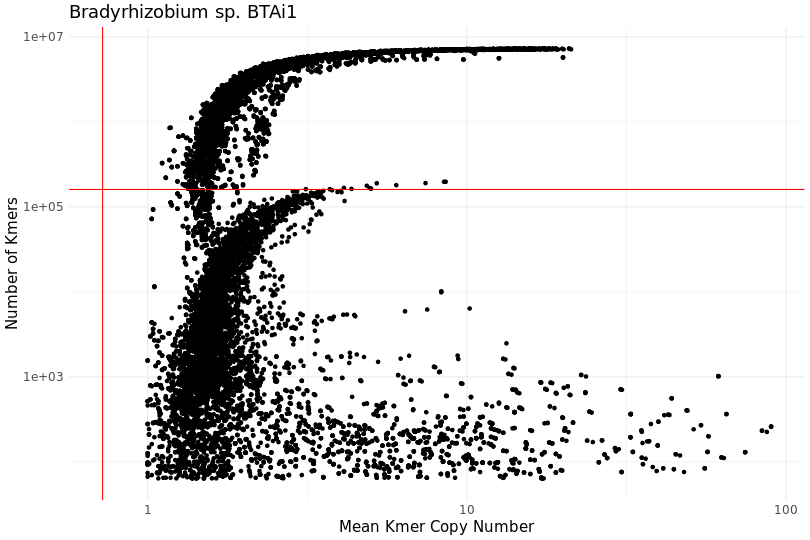

In [6]:
%%R -i brady --height 540 --width 810

dup_cutoff = median(brady$dup) - 2 * mad(brady$dup)
kmer_cutoff = median(brady$kmers) + 2 * mad(brady$kmers)
print(dup_cutoff)
print(kmer_cutoff)
ggplot(brady, aes(x=dup, y=kmers)) +
    geom_point() + 
    ggtitle('Bradyrhizobium sp. BTAi1') +
    geom_hline(yintercept=kmer_cutoff, col='red') +
    geom_vline(xintercept=dup_cutoff, col='red') +
    scale_y_log10() +
    scale_x_log10() +
    theme_minimal() +
    ylab('Number of Kmers') +
    xlab('Mean Kmer Copy Number') + 
    theme_minimal() +
    theme(
        text=element_text(size=15),
    )

In [5]:
taxa.shape

(77, 1783)